# The$\ \beta$-Hermite (Gaussian) Ensembles

Referencing paper : <i>Matrix Models for Beta Ensembles</i>, Ioana Dumitriu and Alan Edelman

- Generation of $\ \beta$-Hermite Gaussian Ensemble as in the paper
- Plot the DPP created by the matrices of this ensemble
- Finfd a dynamic version, a Dyson Brownian motion version.

## 1. Static

In [1]:
%pylab inline
from matplotlib import gridspec
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline
from plot_tools import adjust_spines, sc_law, plot_dpp, plot_traj_with_histo, plot_traj_with_histo_sclaw


Populating the interactive namespace from numpy and matplotlib


In [2]:
def beta_Hermite_Gaussian_ensemble(dim, beta):
    diag = np.diag(np.random.randn(dim))
    u_diag_vect = np.zeros(dim-1)
    for i in range(0,dim-1):
        u_diag_vect[i] = np.sqrt(np.random.chisquare((dim-(i+1))*beta))
    u_diag = np.diag(u_diag_vect,1)
    H_b = diag + u_diag + u_diag.T
    return H_b

In [3]:
# Eigenvalues sample
N = 200
eigenvalues_samples = np.linalg.eigvalsh(beta_Hermite_Gaussian_ensemble(N, 2))

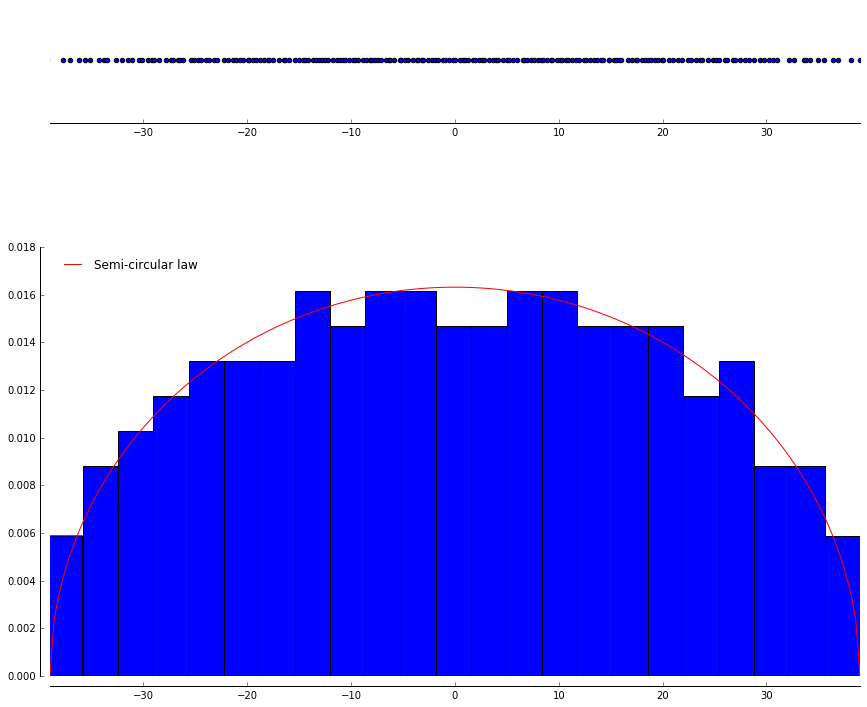

In [4]:
plot_dpp(eigenvalues_samples, './plot/beta_hermite_eigenvalues.png')
plt.savefig('beta_hermite_eigenvalues.png', bbox_inches='tight')

## 2. Dynamic (classic)

In [5]:
class beta_hermite_dpp:
    def __init__(self, n_traj, n_samples, tf, beta, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = tf/n_samples
        self.beta = beta
        self.brownians_list = [ [np.zeros(i*self.beta) for i in range(1, self.n_traj)] ]
        self.diag_list = [ np.zeros(self.n_traj) ]
        self.tridiag_matrices_list = [np.zeros((self.n_traj, self.n_traj))]
        self.generate()
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.diag(rescaling)

    def generate(self):
        for sample in range(self.n_samples-1):
            
            diag = self.diag_list[sample] + np.random.randn(self.n_traj)*(self.dt)**0.5
            self.diag_list.append( diag )
            
            tridiag_matrix = np.diag( diag )
            brownians_sample_list = []
            
            for i in range(1, self.n_traj):
                brownians_sample = self.brownians_list[sample][i-1] + np.random.randn(i*self.beta)*(self.dt)**0.5
                brownians_sample_list.append( brownians_sample )
                
                tridiag_matrix[(self.n_traj-1)-i, (self.n_traj)-i] = np.sqrt( np.sum( brownians_sample**2 ) /2)
                tridiag_matrix[(self.n_traj)-i, (self.n_traj-1)-i] = np.sqrt( np.sum( brownians_sample**2 ) /2)
            
            self.brownians_list.append(brownians_sample_list)
            self.tridiag_matrices_list.append(tridiag_matrix)

    def diag(self, rescaling):
        if rescaling:
            for sample in range(1, self.n_samples):
                eigen_values = sorted(np.real( np.linalg.eigvals(self.tridiag_matrices_list[sample]) ), reverse=True)
                self.eigen_values[sample] = np.multiply(eigen_values, 1/np.sqrt((sample)*self.dt))
                #print(1/np.sqrt((sample+1)*self.dt))
        else:
            for sample in range(1, self.n_samples):
                self.eigen_values[sample] = \
                    sorted(np.real(np.linalg.eigvals(self.tridiag_matrices_list[sample])), reverse=True)

In [6]:
test_beta_hermite_dpp = beta_hermite_dpp(100, 300, 1, beta=2, rescaling=False)

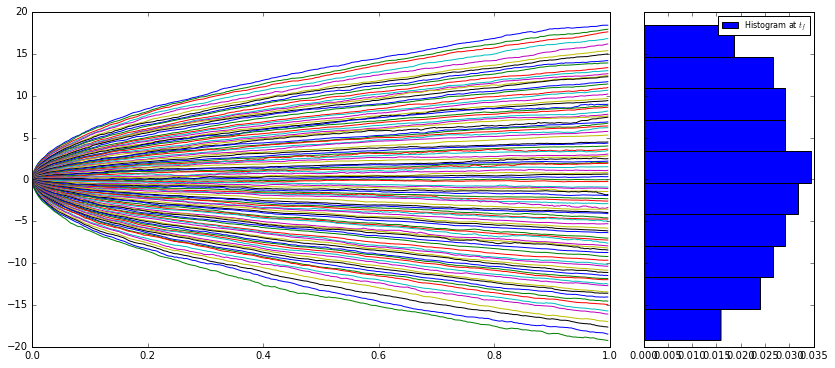

In [7]:
plot_traj_with_histo(test_beta_hermite_dpp, './plot/beta_dbm_histo.png')

## 2. Dynamic (rescale)

In [8]:
test_beta_hermite_dpp_rescale = beta_hermite_dpp(100, 100, 1, beta=2, rescaling=True)

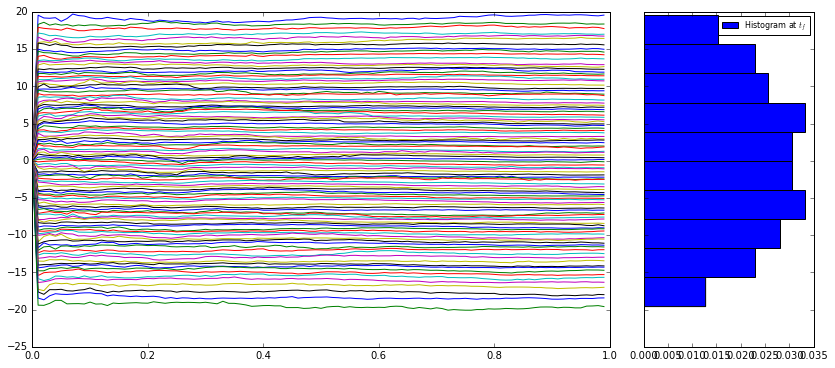

In [10]:
plot_traj_with_histo(test_beta_hermite_dpp_rescale, './plot/beta_dbm_rescale_histo.png')